# Bayesian t-test (JZS method)
In order to compute Bayes factor for comparison of continuous data (against 0 or against another group, paired or not), we rely on the JZS Bayes factor implementation. With this method, a point null hypothesis of 0 is compared against a prior Cauchy distribution with scale of 0.707 (default). I have simply written a wrapper around the penguoin t-test implementation, so that it can easily be applied to time resolved or cross temporal analyses.

The function can perform 3 different kinds of tests:
- A one sample t-test against a specified value: some argument x and scalar (i.e. single number) as y (**decoding accurracy against 0.5 for example**)
- An independent two sample t-test: x and y must have the same shape and paired must be set to false
- A paired sample t-test: x and y must have the same shape and paired must be set to true (**comparing decoding accuracy within subject between two conditions**)

These tests can be performed on 1D, 2D and 3D data (in each case one sample, two sample, independent or not):
- 1D data: apply t-test on a single set of observation (single data point or something like that), for which you must pass a 1D numpy array as x and y matching your expected test
- 2D data: apply t-test on different sets of data points (time point by time point for time resolved signal), for which you must pass a 2D numpy array as x and y matching your expected test
- 3D data: apply t-test on different sets of "pairs" data points (time by time or time by frequency), for which you must pass a 3D numpy array as x and y matching your expected test

The data must be ordered as follows:
- 1D data: (n) n observations
- 2D data: (n, t) n observations at each time point t
- 3D data: (n, t, freq) n observations at each time-frequency "pixel"
- 3D data: (n, t, t) n observations at each time-by-time "pixel"

The function returns a single bayes factor for the 1D data, and an array matching the higher dimension for the others:

Here are concrete examples:

## 1D and 1 sample t-test

In [1]:
from scipy.stats import halfnorm
import numpy as np
import matplotlib.pyplot as plt
from bayes_factor_fun import bayes_ttest, bayes_binomtest, sim_decoding_binomial, sim_decoding_binomial_2d
from mne.stats import bootstrap_confidence_interval

n_subjects = 40

# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=n_subjects)
# Compute the Bayes factor against 0:
bf, pval = bayes_ttest(x, y=0, paired=False, alternative='two-sided', r=0.707, return_pval=True)
print(f'BF10={bf}')
print(f'pval={pval}')

# Generate some data not centered on 0:
x = np.random.normal(0.2, 1, size=n_subjects)
# Compute the Bayes factor against 0:
bf, pval = bayes_ttest(x, y=0, paired=False, alternative='two-sided', r=0.707, return_pval=True)
print(f'BF10={bf}')
print(f'pval={pval}')

# Compare against 0.5
x = np.random.normal(0.2, 1, size=n_subjects)
# Compute the Bayes factor against 0:
bf, pval = bayes_ttest(x, y=0.3, paired=False, alternative='two-sided', r=0.707, return_pval=True)
print(f'BF10={bf}')
print(f'pval={pval}')


We will conduct a one-sample t-test for 1 point(s).
BF10=0.176
pval=0.803202031577186
We will conduct a one-sample t-test for 1 point(s).
BF10=0.753
pval=0.07791270532816565
We will conduct a one-sample t-test for 1 point(s).
BF10=0.179
pval=0.7493112670229582


## 1D and 2 sample independent t-test

In [2]:
# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=n_subjects)
y = np.random.normal(0.3, 1, size=n_subjects)
# Compute the Bayes factor against 0:
bf, pval = bayes_ttest(x, y=y, paired=False, alternative='two-sided', r=0.707, return_pval=True)
print(f'BF10={bf}')
print(f'pval={pval}')

We will conduct a two-sample t-test for 1 point(s).
BF10=3.619
pval=0.013035262736807223


## 1D and 2 sample paired t-test

In [3]:
# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=n_subjects)
y = np.random.normal(0.3, 1, size=n_subjects)
# Compute the Bayes factor against 0:
bf, pval = bayes_ttest(x, y=y, paired=True, alternative='two-sided', r=0.707, return_pval=True)
print(f'BF10={bf}')
print(f'pval={pval}')

We will conduct a paired t-test for 1 point(s).
BF10=3.03
pval=0.01418163369523484


# 2D 1 sample t-test (decoding accuracy against 0.5)

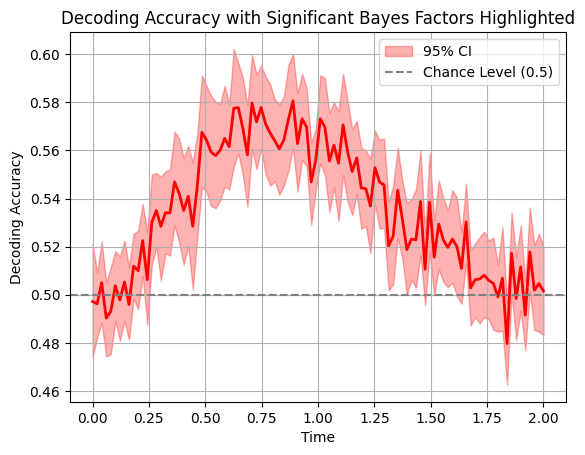

We will conduct a one-sample t-test for 100 point(s).


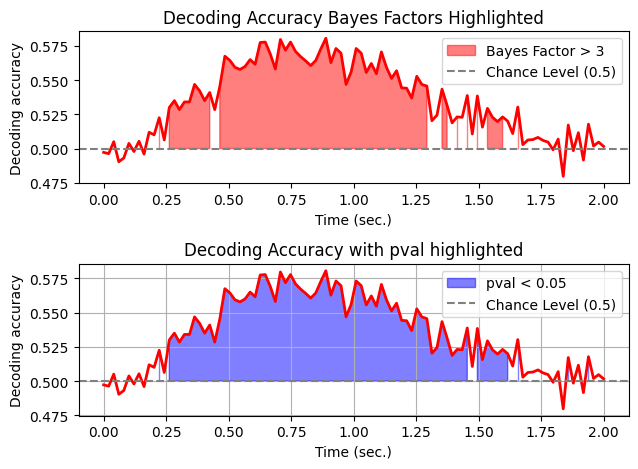

In [4]:
# Additional parameters for the simulation
sfreq = 50
t0 = 0
tmax = 2
times = np.linspace(t0, tmax, sfreq * (tmax - t0))
subjects_decoding = []
ntrials = 80

for sub in range(n_subjects):
    # Simulate decoding accuracy for every subject using a binomial distribution, assuming each subject had a 100 trials:
    sub_decoding = sim_decoding_binomial(t0, tmax, sfreq, scale_factor=np.random.normal(10, 0.3, size=1), tstart=halfnorm.rvs(0, 0.4, size=1), ntrials=ntrials)
    subjects_decoding.append(np.array(sub_decoding) / ntrials)

# Convert to a numpy array:
subjects_decoding = np.asarray(subjects_decoding)
# Calculate mean and 95% CI decoding:
mean_decoding = np.mean(subjects_decoding, axis=0)
ci = bootstrap_confidence_interval(subjects_decoding, ci=0.95)

# We have 20 subjects, times n data points:
subjects_decoding.shape
# Plot the data to illustrate them:
fig, ax = plt.subplots()
ax.plot(times, mean_decoding, linewidth=2, color='r')
ax.fill_between(times, ci[0, :], ci[1, :], color='r', alpha=0.3, label='95% CI')
ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (sec.)')
plt.axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (sec.)')
plt.title("Decoding Accuracy with Significant Bayes Factors Highlighted")
plt.xlabel("Time")
plt.ylabel("Decoding Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Compute the Bayes factor:
bf, pval = bayes_ttest(subjects_decoding, y=0.5, paired=False, alternative='greater', r=0.707, return_pval=True)
# Create a significance mask:
fill_decoding_accuracy_bf = np.where(bf > 3, np.mean(subjects_decoding, axis=0), np.nan)
fill_decoding_accuracy_pval = np.where(pval < 0.05, np.mean(subjects_decoding, axis=0), np.nan)

# Plot the Bayes factor against the decoding accuracy:
fig, ax = plt.subplots(2)
ax[0].plot(times, np.mean(subjects_decoding, axis=0), linewidth=2, color='r')
ax[0].fill_between(times, fill_decoding_accuracy_bf, 0.5, where=bf > 3, 
                 color='red', alpha=0.5, label="Bayes Factor > 3")
ax[0].axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax[0].set_ylabel('Decoding accuracy')
ax[0].set_xlabel('Time (sec.)')
ax[0].set_title("Decoding Accuracy Bayes Factors Highlighted")
ax[0].legend()

ax[1].plot(times, np.mean(subjects_decoding, axis=0), linewidth=2, color='r')
ax[1].fill_between(times, fill_decoding_accuracy_pval, 0.5, where=pval < 0.05, 
                 color='blue', alpha=0.5, label="pval < 0.05")
ax[1].axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax[1].set_ylabel('Decoding accuracy')
ax[1].set_xlabel('Time (sec.)')
ax[1].set_title("Decoding Accuracy with pval highlighted")
ax[1].legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# 2D paired t-test

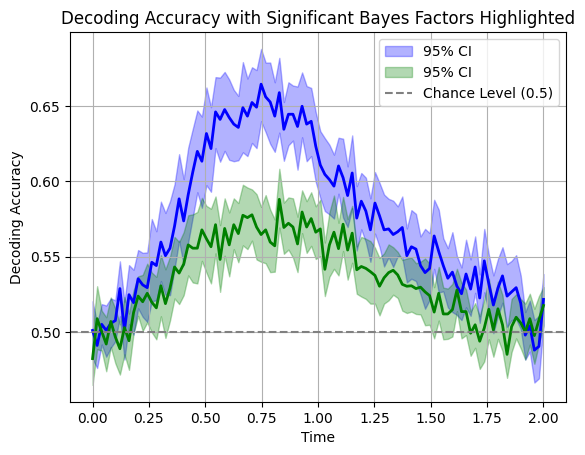

We will conduct a paired t-test for 100 point(s).


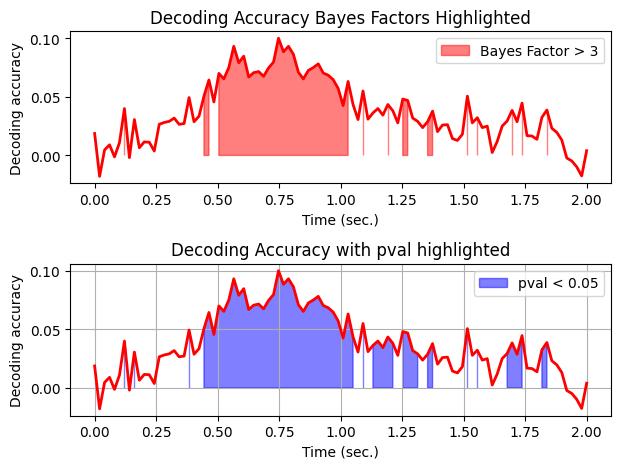

In [5]:
# Add a difference between two conditions within subject:
scale_factor_cond1 = 5  # Control the height of the decoding accuracy
scale_factor_cond2 = 10  
subjects_decoding_cond1 = []
subjects_decoding_cond2 = []

for sub in range(n_subjects):
    # Simulate decoding accuracy for every subject using a binomial distribution, assuming each subject had a 100 trials:
    sub_decoding_cond1 = sim_decoding_binomial(t0, tmax, sfreq, scale_factor=np.random.normal(scale_factor_cond1, 0.3, size=1), tstart=halfnorm.rvs(0, 0.4, size=1), ntrials=ntrials)
    sub_decoding_cond2 = sim_decoding_binomial(t0, tmax, sfreq, scale_factor=np.random.normal(scale_factor_cond2, 0.3, size=1), tstart=halfnorm.rvs(0, 0.4, size=1), ntrials=ntrials)
    
    # Append to the rest:
    subjects_decoding_cond1.append(np.array(sub_decoding_cond1) / ntrials)
    subjects_decoding_cond2.append(np.array(sub_decoding_cond2) / ntrials)

# Convert to a numpy array:
subjects_decoding_cond1 = np.asarray(subjects_decoding_cond1)
subjects_decoding_cond2 = np.asarray(subjects_decoding_cond2)

# Calculate mean and 95% CI decoding:
mean_decoding_cond1 = np.mean(subjects_decoding_cond1, axis=0)
ci_cond1 = bootstrap_confidence_interval(subjects_decoding_cond1, ci=0.95)
mean_decoding_cond2 = np.mean(subjects_decoding_cond2, axis=0)
ci_cond2 = bootstrap_confidence_interval(subjects_decoding_cond2, ci=0.95)


# We have 20 subjects, times n data points:
subjects_decoding.shape
# Plot the data to illustrate them:
fig, ax = plt.subplots()
ax.plot(times, mean_decoding_cond1, linewidth=2, color='b')
ax.plot(times, mean_decoding_cond2, linewidth=2, color='g')

ax.fill_between(times, ci_cond1[0, :], ci_cond1[1, :], color='b', alpha=0.3, label='95% CI')
ax.fill_between(times, ci_cond2[0, :], ci_cond2[1, :], color='g', alpha=0.3, label='95% CI')

ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (sec.)')
plt.axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (sec.)')
plt.title("Decoding Accuracy with Significant Bayes Factors Highlighted")
plt.xlabel("Time")
plt.ylabel("Decoding Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Compute the Bayes factor:
bf, pval = bayes_ttest(subjects_decoding_cond1, subjects_decoding_cond2, paired=True, alternative='two-sided', r=0.707, return_pval=True)
# Create a significance mask:
fill_decoding_accuracy_bf = np.where(bf > 3, mean_decoding_cond1 - mean_decoding_cond2, np.nan)
fill_decoding_accuracy_pval = np.where(pval < 0.05, mean_decoding_cond1 - mean_decoding_cond2, np.nan)

# Plot the Bayes factor against the decoding accuracy:
fig, ax = plt.subplots(2)
ax[0].plot(times, mean_decoding_cond1 - mean_decoding_cond2, linewidth=2, color='r')
ax[0].fill_between(times, fill_decoding_accuracy_bf, 0, where=bf > 3, 
                 color='red', alpha=0.5, label="Bayes Factor > 3")
ax[0].set_ylabel('Decoding accuracy')
ax[0].set_xlabel('Time (sec.)')
ax[0].set_title("Decoding Accuracy Bayes Factors Highlighted")
ax[0].legend()

ax[1].plot(times, mean_decoding_cond1 - mean_decoding_cond2, linewidth=2, color='r')
ax[1].fill_between(times, fill_decoding_accuracy_pval, 0, where=pval<0.05, 
                 color='blue', alpha=0.5, label="pval < 0.05")
ax[1].set_ylabel('Decoding accuracy')
ax[1].set_xlabel('Time (sec.)')
ax[1].set_title("Decoding Accuracy with pval highlighted")
ax[1].legend()

plt.tight_layout()
plt.grid(True)
plt.show()


# 3D One sample test (timextime decoding accuracy)

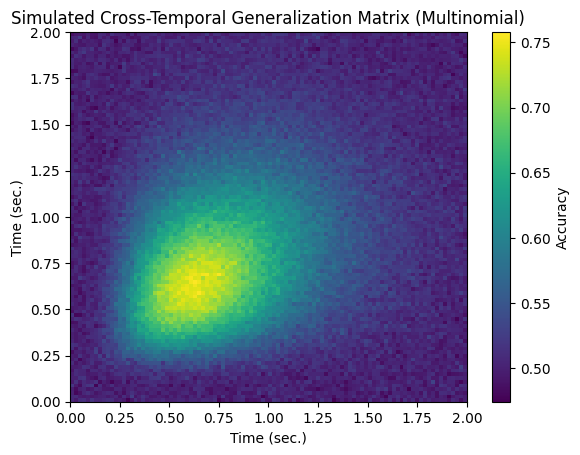

We will conduct a one-sample t-test for 10000 point(s).


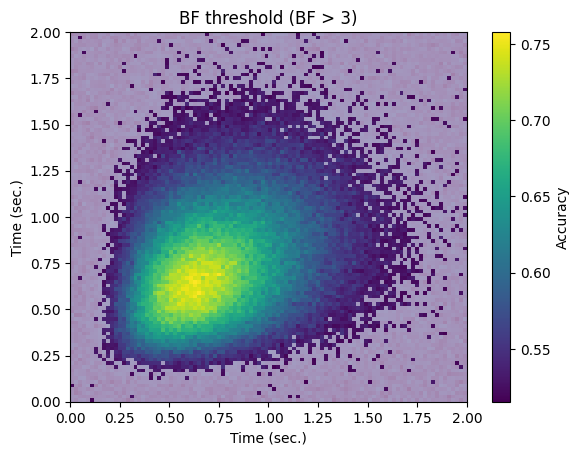

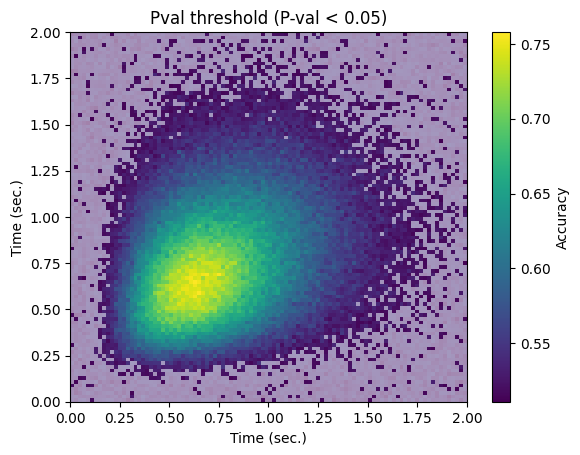

In [6]:
# Simulate 2D temporal generalization matrices:
subjects_decoding = []
for sub in range(n_subjects):
    # Simulate decoding accuracy for every subject using a binomial distribution, assuming each subject had a 100 trials:
    sub_decoding = sim_decoding_binomial_2d(t0, tmax, sfreq, scale_factor=np.random.normal(3, 0.3, size=1), tstart=halfnorm.rvs(0, 0.4, size=1), ntrials=ntrials)
    subjects_decoding.append(np.array(sub_decoding) / ntrials)

# Compute the average decoding:
subjects_decoding = np.asarray(subjects_decoding)
# Calculate mean decoding:
mean_decoding = np.mean(subjects_decoding, axis=0)

# Plot the simulated multinomial matrix
plt.figure()
plt.imshow(mean_decoding, aspect='auto', origin='lower', cmap='viridis', extent=[t0, tmax, t0, tmax])
plt.colorbar(label='Accuracy')
plt.title('Simulated Cross-Temporal Generalization Matrix (Multinomial)')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()

# Compute the Bayes factor
bf, pval = bayes_ttest(subjects_decoding, y=0.5, paired=False, alternative='greater', r=0.707, return_pval=True)
# Convert to a Mask:
mean_decoding_bf = mean_decoding.copy()
mean_decoding_bf[~(bf > 3)] = np.nan
mean_decoding_pval = mean_decoding.copy()
mean_decoding_pval[~(pval < 0.05)] = np.nan

fig, ax = plt.subplots()
# Plot the full decoding matrix with partial transparency
im1 = ax.imshow(mean_decoding, aspect='auto', origin='lower', cmap='viridis', 
               extent=[t0, tmax, t0, tmax], alpha=0.5)

# Overlay only the significant values, fully opaque
im2 = ax.imshow(mean_decoding_bf, aspect='auto', origin='lower', cmap='viridis', 
          extent=[t0, tmax, t0, tmax], alpha=1.0)
ax.set_title('BF threshold (BF > 3)')
plt.colorbar(im2, label='Accuracy')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()

fig, ax = plt.subplots()
# Plot the full decoding matrix with partial transparency
im1 = ax.imshow(mean_decoding, aspect='auto', origin='lower', cmap='viridis', 
               extent=[t0, tmax, t0, tmax], alpha=0.5)

# Overlay only the significant values, fully opaque
im2 = ax.imshow(mean_decoding_pval, aspect='auto', origin='lower', cmap='viridis', 
          extent=[t0, tmax, t0, tmax], alpha=1.0)
ax.set_title('Pval threshold (P-val < 0.05)')
plt.colorbar(im2, label='Accuracy')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()

# Bayes Binomial test

In order to compute a Bayes factor for the binomial distribution, we are using beta-binomial test. The likelihood of the data is defined by the beta distribution, while the prior is defined with a beta distribution. Since the two are conjugate, we can compute the model evidence analytically. We are therefore comparing the model evidence between a point null hypothesis ($P(\Theta=0.5) = 1$) against an alternative hypothesis of a flat prior: all decoding accuracies are equally likely.

The function below is a wrapper on the penguin function bayesfactor_binom, which allows you to specify the null hypothesis as a single value for probability of success (i.e. chance=0.5) as well as your prior for the alternative hypothesis. The default is $\alpha=1$ and $\beta=1$, which is a flat prior between 0 and 1 (i.e. all decoding accuracy values are equally likely a priori)

The function take the following input:
- k: (floats or ints, or array of floats or ints, 1D or 2D) number of success (i.e. correct decoding) OR a decoding accuracy (between 0 and 1). If you pass a float(s) between 0 and 1, the probability of success will be calcuated in the background by multiplying it by the number of trials n. Note that if that doesn't fall straight (due to averaging across cross validation folds for example), you will get a warning. 
- n: (int) number of trials
- p: (float) null hypothesis, default 0.5 (i.e. chance for binary classifier)
- a: prior parameter for the beta distribution (default to 1, flat prior when b is also 1)
- b: prior parameter for the beta distribution (default to 1, flat prior when a is also 1)

Similar to the Bayes t-test, these tests can be performed on 1D and 2D data. CAREFUL: this test is not meant to compute Bayes factor across subject. The test is performed on single decoding accuracy values, not on distribution thereof across subjects! Accordingly, the data must be order as follows:
- 0D data: () a single decoding accuracy data, for which you want a Bayes factor
- 1D data: (n) n decoding accuracy values. If you are working with time resolved data, each decoding accuracy can be the decoding accuracy at one time point
- 2D data: (n, m) n by m decoding accuracy values. If you are working with cross temporal generalization matrices for example, this will yield a n by m bayes factors!

# Single accuracy value BF

In [7]:
# Generate a random number of successes from a true probabiliy of success of 0.7:
accuracy = np.random.binomial(ntrials, 0.7)
bf, pval = bayes_binomtest(accuracy, ntrials, p=0.5, a=1, b=1, return_pval=True)
print(f'Observed success: {accuracy}/{ntrials}')
print(f'BF10={round(bf, 3)}')
print(f'pval={round(pval, 3)}')

Conducting 1 binomial Bayes factor test(s).
Observed success: 57/80
BF10=218.487
pval=0.0


# Time resolved decoding accuracy:

Conducting 100 binomial Bayes factor test(s).


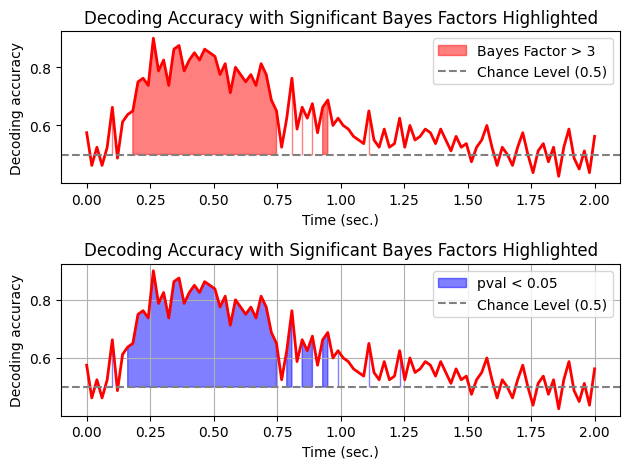

In [8]:
# Simulate decoding accuracy time series:
decoding = sim_decoding_binomial(t0, tmax, sfreq, scale_factor=3, tstart=0, ntrials=ntrials)
decoding = np.asarray(decoding)
# Calcuate the Bayes factor:
bf, pval = bayes_binomtest(decoding, ntrials, p=0.5, a=1, b=1, return_pval=True)
# Create a significance mask:
fill_decoding_accuracy_bf = np.where(bf > 3, decoding / ntrials, np.nan)
fill_decoding_accuracy_pval = np.where(pval < 0.05, decoding / ntrials, np.nan)

# Plot the results with the Bayes factor and p value:
fig, ax = plt.subplots(2)
ax[0].plot(times, decoding / ntrials, linewidth=2, color='r')
ax[0].fill_between(times, fill_decoding_accuracy_bf, 0.5, where=bf > 3, 
                 color='red', alpha=0.5, label="Bayes Factor > 3")
ax[0].axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax[0].set_ylabel('Decoding accuracy')
ax[0].set_xlabel('Time (sec.)')
ax[0].set_title("Decoding Accuracy with Significant Bayes Factors Highlighted")
ax[0].legend()

ax[1].plot(times, decoding / ntrials, linewidth=2, color='r')
ax[1].fill_between(times, fill_decoding_accuracy_pval, 0.5, where=pval<0.05, 
                 color='blue', alpha=0.5, label="pval < 0.05")
ax[1].axhline(0.5, color='gray', linestyle='--', label="Chance Level (0.5)")
ax[1].set_ylabel('Decoding accuracy')
ax[1].set_xlabel('Time (sec.)')
ax[1].set_title("Decoding Accuracy with Significant Bayes Factors Highlighted")
ax[1].legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# 2D binomial test: cross temporal generalization decoding:


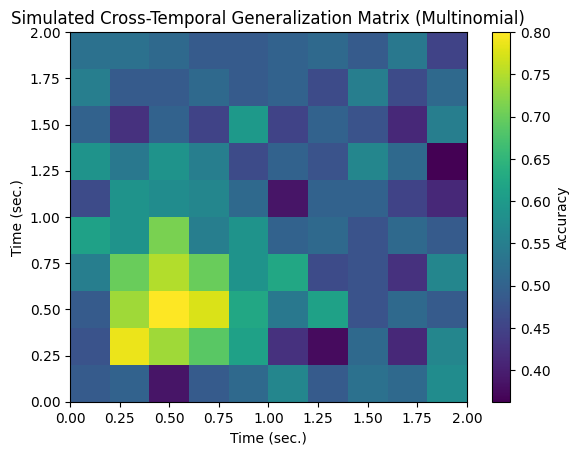

Conducting 100 binomial Bayes factor test(s).


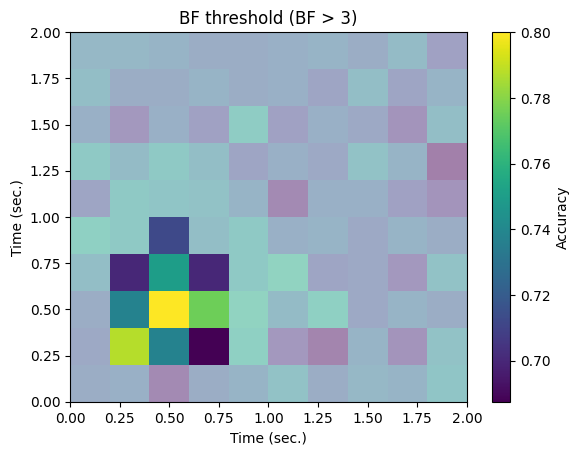

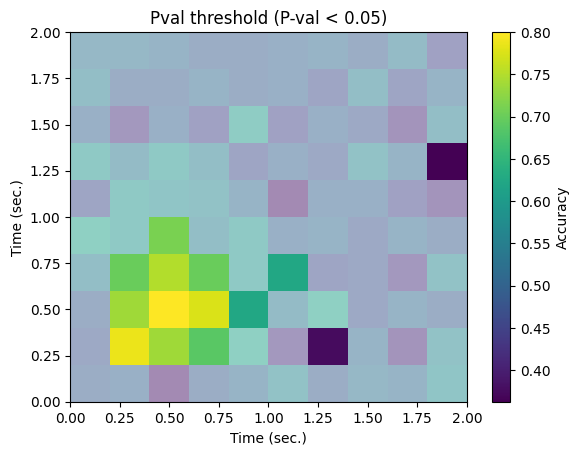

In [ ]:
# SImulate data with the same parameters as before, but 2D:
decoding = sim_decoding_binomial_2d(t0, tmax, sfreq, scale_factor=3, tstart=0, ntrials=ntrials)
decoding = np.asarray(decoding/ntrials)
# Plot the simulated multinomial matrix
plt.figure()
plt.imshow(decoding, aspect='auto', origin='lower', cmap='viridis', extent=[t0, tmax, t0, tmax])
plt.colorbar(label='Accuracy')
plt.title('Simulated Cross-Temporal Generalization Matrix (Multinomial)')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()

# Calcuate the Bayes factor:
bf, pval = bayes_binomtest(decoding, ntrials, p=0.5, a=1, b=1, return_pval=True)
# Convert to a Mask:
decoding_bf = decoding.copy()
decoding_bf[~(bf > 3)] = np.nan
decoding_pval = decoding.copy()
decoding_pval[~(pval < 0.05)] = np.nan

fig, ax = plt.subplots()
# Plot the full decoding matrix with partial transparency
im1 = ax.imshow(decoding, aspect='auto', origin='lower', cmap='viridis', 
               extent=[t0, tmax, t0, tmax], alpha=0.5)

# Overlay only the significant values, fully opaque
im2 = ax.imshow(decoding_bf, aspect='auto', origin='lower', cmap='viridis', 
          extent=[t0, tmax, t0, tmax], alpha=1.0)
ax.set_title('BF threshold (BF > 3)')
plt.colorbar(im2, label='Accuracy')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()

fig, ax = plt.subplots()
# Plot the full decoding matrix with partial transparency
im1 = ax.imshow(decoding, aspect='auto', origin='lower', cmap='viridis', 
               extent=[t0, tmax, t0, tmax], alpha=0.5)

# Overlay only the significant values, fully opaque
im2 = ax.imshow(decoding_pval, aspect='auto', origin='lower', cmap='viridis', 
          extent=[t0, tmax, t0, tmax], alpha=1.0)
ax.set_title('Pval threshold (P-val < 0.05)')
plt.colorbar(im2, label='Accuracy')
plt.xlabel('Time (sec.)')
plt.ylabel('Time (sec.)')
plt.show()